In [4]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

In [6]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'elephants.png'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
decode_predictions(preds, top=3)[0]

40960/35363 [==================================] - 0s 6us/step


[('n02504458', 'African_elephant', 0.86432326),
 ('n01871265', 'tusker', 0.12544774),
 ('n02504013', 'Indian_elephant', 0.0100667095)]

In [7]:
np.argmax(preds[0])

386

In [12]:
from keras import backend as K

african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

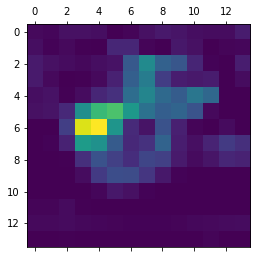

In [15]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [18]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img
cv2.imwrite('elephant_cam.jpg', superimposed_img)

True